## **M1. Actividad**

Ana Karen López Baltazar - A01707750

## **Librerías**

In [1]:
# Instalación de Mesa
!pip install mesa

# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model 

# Debido a que necesitamos que exista más de un agente por celda, elegimos ''MultiGrid''.
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que los agentes se activen ''aleatoriamente''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.1 MB/s 
     |████████████████████████████████| 66 kB 1.9 MB/s 


## **Funciones auxiliares**

In [67]:
MAXVAL = 10000

def get_grid(model):
  grid = np.zeros((model.grid.height, model.grid.width))
  for ren in range(model.grid.width):
      for col in range(model.grid.height):
          if model.grid.is_cell_empty((ren, col)):
              grid[ren][col] = model.floor[ren][col] * 2
          else:
              grid[ren][col] = 1
  return grid    

## **Agente**

In [3]:
class RobotVacuumCleanerAgent (Agent):
  def __init__(self, unique_id, model):
    # Inicialiazación y variables del agente
    super().__init__(unique_id, model)
    self.options = np.array([ [-1, -1], [-1,  0], [-1, +1],
                              [ 0, -1],           [ 0, +1],
                              [+1, -1], [+1,  0], [+1, +1] ])
    self.movements = 0
      
  def step(self):
    if self.model.floor[self.pos[0]][self.pos[1]] == 1:
      # Limpiar la celda actual si está sucia
      self.model.floor[self.pos[0]][self.pos[1]] = 0  
    else:
      # Moverse a otra celda mientras sea posible
      i = int( np.random.rand() * MAXVAL ) % len(self.options)
      x = self.pos[0] + self.options[i][0]
      y = self.pos[1] + self.options[i][1]

      if self.can_move(x, y):
        self.model.grid.move_agent(self, (x, y))
        self.movements += 1

  def can_move(self, x, y):
    # ¿Es posible el siguiente movimiento del agente?
    return (x >= 0 and x < self.model.grid.width and 
                y >= 0 and y < self.model.grid.height)

## **Modelo**

In [80]:
class RobotVacuumCleanerModel (Model):
  def __init__(self, width, height, num_agents, dirty_cells_percentage, max_steps = float('inf')):
    # Variables del modelo
    self.num_agents = num_agents
    self.dirty_cells_percentage = dirty_cells_percentage
    self.grid = MultiGrid(width, height, True)
    self.schedule = RandomActivation(self)
    self.max_steps = max_steps
    self.max_steps_reached = False
    self.steps = 0

    # Control del tiempo
    # self.max_time = seconds
    # self.start_time = time.time()
    # self.last_time = time.time()
    # self.time_elapsed = datetime.timedelta(time.time() - self.start_time)
    # self.time_exceeded = False
      
    self.floor = np.zeros((width, height))
    amount = int((width * height) * dirty_cells_percentage)

    # Inicializacón de celdas 'sucias'      
    for i in range(amount):
        finished = False
        while not finished:
          x = int(np.random.rand() * MAXVAL) % width
          y = int(np.random.rand() * MAXVAL) % height
          
          if self.floor[x][y] == 0:
            self.floor[x][y] = 1
            finished = True
      
    # Creación de agentes
    for i in range(self.num_agents):
      a = RobotVacuumCleanerAgent(i, self)
      self.grid.place_agent(a, (1, 1))
      self.schedule.add(a)

    # Recolección de info. del modelo          
    self.datacollector = DataCollector(model_reporters = {"Grid": get_grid})
        
  def step(self):
    # Paso de la simulación
    self.datacollector.collect(self)
    self.schedule.step()
    self.steps += 1
      
    # Límite de pasos excedido
    if self.steps + 1 > self.max_steps:
      self.datacollector.collect(self)
      self.max_steps_reached = True      

    # Habitación limpia
    if self.is_all_clean():
      self.datacollector.collect(self)

    # Registro del tiempo de la simulación
    # self.time_elapsed = datetime.timedelta(time.time() - self.start_time)
    # self.last_time = time.time() 

    # Tiempo límite excedido
    # if self.last_time > (self.start_time + self.max_time):
      # self.datacollector.collect(self)
      # self.time_exceeded = True
    
  def is_all_clean(self):
    # Estado de la habitación
    return np.all(self.floor == 0)

  def clean_percentage(self):
    # Porcentaje de celdas limpias
    if self.is_all_clean():
      return 100
    else:
      total = self.grid.width * self.grid.height
      dirty_cells = self.floor.sum()
      return 100 - ((dirty_cells * 100) / total)

## **Ejecución - Con límite de pasos**

In [134]:
# Simulación con límite de pasos establecido
MAX_ITERATIONS = 200
WIDTH = 20
HEIGHT = 20
AGENTS = 100
DIRTY_CELLS_PERCENTAGE = 0.5
MAX_SECONDS = 0.1

start_time = time.time()
model = RobotVacuumCleanerModel(WIDTH, HEIGHT, AGENTS, DIRTY_CELLS_PERCENTAGE, MAX_ITERATIONS)
i = 1

while not model.is_all_clean() and not model.max_steps_reached:
    model.step()
    i += 1

print ("Pasos de la simulación:", i - 1)
print ("Límite de pasos alcanzado:", model.max_steps_reached)
print ("Tiempo de ejecución:", round(time.time() - start_time, 4), "s")
print ("Porcentaje de celdas limpias:", model.clean_percentage(), "%")

agents_movements = [agent.movements for agent in model.schedule.agents]
avg_movements = avg = sum(agents_movements)/len(agents_movements)
print ("Movimientos promedio por agente:", round(avg_movements), "pasos")

Pasos de la simulación: 179
Límite de pasos alcanzado: False
Tiempo de ejecución: 0.4074 s
Porcentaje de celdas limpias: 100 %
Movimientos promedio por agente: 160 pasos


In [135]:
all_grid = model.datacollector.get_model_vars_dataframe()

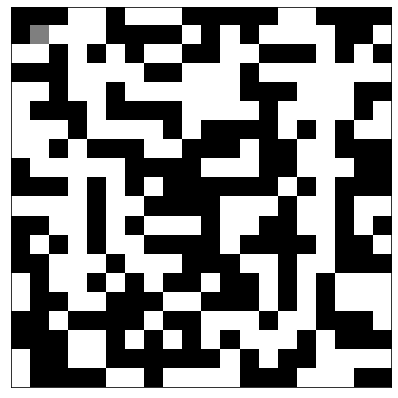

In [136]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = i - 1)

In [137]:
anim

Text(0, 0.5, 'Frecuencia')

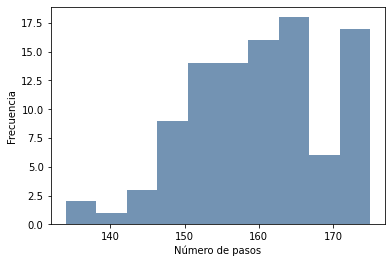

In [138]:
plt.hist(agents_movements, color='#7393b3')
plt.xlabel('Número de pasos')
plt.ylabel('Frecuencia')

## **Ejecución - Sin límite de pasos**

In [139]:
# Simulación sin límite de pasos establecido
WIDTH = 20
HEIGHT = 20
AGENTS = 100
DIRTY_CELLS_PERCENTAGE = 0.5
MAX_SECONDS = 0.1

start_time = time.time()
model = RobotVacuumCleanerModel(WIDTH, HEIGHT, AGENTS, DIRTY_CELLS_PERCENTAGE)
i = 1

while not model.is_all_clean():
    model.step()
    i += 1

print ("Pasos de la simulación:", i - 1)
print ("Tiempo de ejecución:", round(time.time() - start_time, 4), "s")
print ("Porcentaje de celdas limpias:", model.clean_percentage(), "%")

agents_movements = [agent.movements for agent in model.schedule.agents]
avg_movements = avg = sum(agents_movements)/len(agents_movements)
print ("Movimientos promedio por agente:", round(avg_movements), "pasos")

Pasos de la simulación: 180
Tiempo de ejecución: 0.2586 s
Porcentaje de celdas limpias: 100 %
Movimientos promedio por agente: 161 pasos


In [140]:
all_grid = model.datacollector.get_model_vars_dataframe()

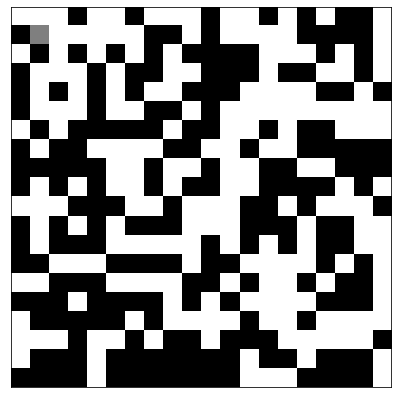

In [141]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.binary)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames = i - 1)

In [142]:
anim

Text(0, 0.5, 'Frecuencia')

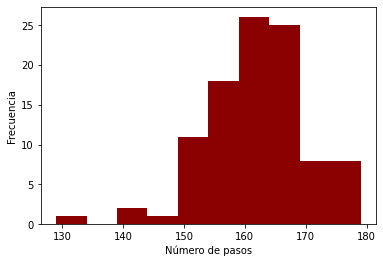

In [143]:
plt.hist(agents_movements, color='#8b0000')
plt.xlabel('Número de pasos')
plt.ylabel('Frecuencia')